# Variational AutoEncoder

Questo notebook implementa una Variational Autoencoder (VAE) progettata per apprendere una rappresentazione latente dei loghi nel dataset LLD (Large Logo Dataset: https://data.vision.ee.ethz.ch/sagea/lld/) e generare nuove varianti con il decoder.

Il modello è composto da:

- Encoder: comprime l'immagine in un vettore latente, mappandolo in una distribuzione probabilistica (media e varianza logaritmica).
- Latent Space Sampling: utilizza il reparametrization trick per campionare il vettore latente in modo differenziabile.
- Decoder: riconverte il vettore latente in un'immagine, cercando di ricostruire il logo originale.

L'obiettivo è allenare il modello affinché il suo spazio latente catturi caratteristiche significative dei loghi, permettendo la generazione di nuove varianti coerenti (https://keras.io/examples/generative/vae/).

Come ultimo step si effettua il calcolo della FID tra le immagini generate e quelle del dataset (https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/).

##Librerie

Importiamo le librerie necessarie e configuriamo l’esecuzione eager.

In [ ]:
# Importazione delle librerie principali
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, ops

# Importazione di librerie per la manipolazione dei dati e operazioni matematiche
import numpy as np
from numpy import cov, trace, iscomplexobj, asarray
import shutil
from scipy.linalg import sqrtm
from skimage.transform import resize

# Importazione di librerie per la visualizzazione grafica
import matplotlib.pyplot as plt

# Salvataggio pesi del modello
from tensorflow.keras.callbacks import ModelCheckpoint

# Gestione percorsi file e zip
import os
from pathlib import Path
from zipfile import ZipFile

# Forza l'esecuzione in modalità "eager" per eviatre il sovraccarico della RAM
tf.config.run_functions_eagerly(True)

# Importazione del modello InceptionV3 e della funzione per il preprocessamento delle immagini.
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize

In [ ]:
# Monta Google Drive per accedere ai file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Preparazione del dataset

Estraiamo il file ZIP contenente i loghi e creiamo una directory locale per i dati.

In [ ]:
# Specifica del percorso del dataset ZIP presente su Google Drive
dataset_path = '/content/drive/MyDrive/LLD-icon_PNG.zip'

# Creazione della directory locale "LLD_gan" per estrarre il dataset, se non esiste già
output_dir = "LLD_gan"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Estrazione del file ZIP nella directory di output
with ZipFile(dataset_path, "r") as zipobj:
    zipobj.extractall(output_dir)

##Caricamento e preprocessing del dataset

Carichiamo le immagini dal dataset, le ridimensioniamo a 32x32 pixel e le normalizziamo nel range [0,1].

In [ ]:
# Carica il dataset dalle immagini contenute nella directory "LLD_gan"
dataset = keras.utils.image_dataset_from_directory(
    "LLD_gan", # Directory contenente le immagini
    label_mode=None, # Non usiamo etichette perché ci interessa solo la generazione
    image_size=(32, 32), # Ridimensiona le immagini a 32x32 pixel
    batch_size=512 # Numero di immagini per batch
)

# Normalizza le immagini, portando i pixel nel range [0, 1]
dataset = dataset.map(lambda x: x / 255.0)

Found 485377 files.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


#Architettura della rete

## Strato di campionamento


Definiamo lo strato di campionamento che, usando la media e la log-varianza ottenute dall’encoder, applica il reparameterization trick. In questo modo, trasformiamo il vettore casuale (con dimensione latente 128) in un vettore latente z, garantendo la propagazione del gradiente durante l’addestramento.

In [ ]:
# Creazione classe di Sampling
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        """
        Inizializza il livello Sampling per il campionamento del vettore latente z
        """
        super().__init__(**kwargs)

        # Inizializza un generatore di seed per garantire la ripetibilità nel campionamento
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        """
        Esegue il campionamento del vettore latente z utilizzando il reparametrization trick
        Args:
            inputs: tupla contenente (z_mean, z_log_var)
                z_mean: media dello spazio latente
                z_log_var: logaritmo della varianza dello spazio latente
        Return:
            z: vettore latente campionato
        """
        # Separa la media e la log-varianza dallo spazio latente
        z_mean, z_log_var = inputs

        # Determina la dimensione del batch e la dimensione dello spazio latente
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]

        # Genera rumore casuale epsilon dalla distribuzione normale, utilizzando il generatore di seed per la riproducibilità
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)

        # Applica il reparametrization trick per ottenere il vettore latente campionato
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


## Encoder

Costruiamo l’encoder del VAE:

L’input sono immagini 32×32x3.
1. Utilizziamo strati convoluzionali per ridurre progressivamente la dimensione spaziale e aumentare il numero dei canali.
2. Il tensore risultante viene appiattito e passato a un layer Dense per ottenere una rappresentazione compatta
3. Applichiamo un Dropout di 0.3 per ridurre l’overfitting.
4. Infine, calcoliamo la media (z_mean) e la log-varianza (z_log_var) e campioniamo il vettore latente z tramite lo strato Sampling.

In [ ]:
# Dimensione del vettore latente
latent_dim = 128

# Input: immagini 32x32 con 3 canali (RGB)
encoder_inputs = keras.Input(shape=(32, 32, 3))

# Primo livello convoluzionale per ridurre la dimensione
x = layers.Conv2D(64, kernel_size=3, activation="relu", strides=2, padding="same")(encoder_inputs)
# Secondo livello convoluzionale
x = layers.Conv2D(128, kernel_size=3, activation="relu", strides=2, padding="same")(x)

# Appiattisce il tensore
x = layers.Flatten()(x)
# Passaggio tramite un layer Dense per ottenere una rappresentazione compatta
x = layers.Dense(128, activation="relu")(x)

# Applica il Dropout per evitare overfitting
x = layers.Dropout(0.3)(x)

# Ottiene la media e il log della varianza per lo spazio latente
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Campiona il vettore latente usando lo strato Sampling
z = Sampling()([z_mean, z_log_var])

# Definisce il modello encoder che restituisce (z_mean, z_log_var, z)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Visualizza il sommario del modello encoder
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      1,048,704 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 128)            │         16,512 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 128)            │         16,512 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 128)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,157,376 (4.42 MB)

 Trainable params: 1,157,376 (4.42 MB)

 Non-trainable params: 0 (0.00 B)

##Decoder

Il decoder trasforma un vettore casuale (dimensione 128) in un'immagine 32x32 a colori.
1. Un layer Dense trasforma il vettore in un tensore 3D (8,8,128).
2. I layers Conv2DTranspose aumentano progressivamente la dimensione.
3. Ogni layer utilizza LeakyReLU per la non linearità.
4. L'output è un'immagine RGB con attivazione sigmoide per normalizzare i valori. Questo perché aiuta la stabilità numerica e facilita la convergenza durante l'addestramento.




In [ ]:
# Input: vettore latente di dimensione "latent_dim"
latent_inputs = keras.Input(shape=(latent_dim,))

# Espande il vettore latente in un volume 8x8 con 128 canali
x = layers.Dense(8 * 8 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 128))(x)

# Prima convoluzione trasposta per aumentare la risoluzione
x = layers.Conv2DTranspose(128, kernel_size=3, activation="relu", strides=2, padding="same")(x)
# Seconda convoluzione trasposta
x = layers.Conv2DTranspose(64, kernel_size=3, activation="relu", strides=2, padding="same")(x)

# Layer finale trasposto per ricostruire l'immagine RGB con attivazione sigmoid
decoder_outputs = layers.Conv2DTranspose(3, kernel_size=3, activation="sigmoid", padding="same")(x)

# Definisce il modello decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Visualizza il sommario del modello encoder
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,279,875 (4.88 MB)

 Trainable params: 1,279,875 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

#Modello VAE

## Creazione della classe VAE

Definiamo una classe personalizzata per il VAE che integra encoder e decoder e implementa un metodo di addestramento custom.

Viene calcolata la reconstruction loss (Binary Cross-Entropy) e la KL divergence che penalizza la differenza fra la distribuzione latente e una normale standard.
La loss totale è la somma delle due componenti e i gradienti vengono aggiornati tramite l’ottimizzatore.

In [1]:
# Crea una classe che eredita da keras.Model per definire il comportamento della VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        """
        Inizializza il modello VAE.
        Args:
            encoder: il modello encoder
            decoder: il modello decoder
            kwargs: numero arbitrario di argomenti
        """
        self.encoder = encoder
        self.decoder = decoder

        # Crea dei tracker per monitorare le metriche di loss durante l'addestramento
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        # Ritorna la lista delle metriche da monitorare
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        # Calcola le loss con GradientTape
        with tf.GradientTape() as tape:
            # Passa i dati attraverso l'encoder per ottenere (z_mean, z_log_var, z)
            z_mean, z_log_var, z = self.encoder(data)
            # Ricostruisce l'immagine dal vettore latente
            reconstruction = self.decoder(z)
            # Calcola la Reconstruction Loss (Binary Cross-Entropy)
            reconstruction_loss = ops.mean(
                ops.sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)),
                axis=0
            )
            # Calcola la KL Divergence che penalizza la differenza tra la distribuzione latente e la distribuzione normale standard
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            # La loss totale è la somma della Reconstruction Loss e della KL Divergence
            total_loss = reconstruction_loss + kl_loss
        # Calcola i gradienti rispetto ai pesi addestrabili
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Applica gli aggiornamenti dei pesi tramite l'ottimizzatore
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Aggiorna i tracker delle metriche
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Restituisce le metriche per il log
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

NameError: name 'keras' is not defined

##Salvataggio delle immagini generate

Implementiamo un callback per salvare le immagini generate ad ogni epoca e copiarle su Google Drive.

In [ ]:
# Definisce una classe Callback per salvare le immagini ad ogni epoca
class VAEMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=128, output_dir="generated_images_VAE"):
        """
        Inizializza il monitor per salvare le immagini generate.
        Args:
            decoder: il decoder del VAE.
            num_img: numero di immagini da generare per ogni epoca.
            latent_dim: dimensione dello spazio latente.
            output_dir: directory in cui salvare le immagini.
        """
        self.decoder = decoder
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.output_dir = output_dir

        # Crea la directory se non esiste
        os.makedirs(self.output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        """
        Al termine di ogni epoca:
            Genera alcune immagini.
            Salva le immagini in una sottocartella dedicata all'epoca corrente.
            Copia le immagini salvate su Google Drive per backup.
        """
        epoch_dir = os.path.join(self.output_dir, f"epoca_{epoch + 1}")
        os.makedirs(epoch_dir, exist_ok=True)

        # Genera dei vettori casuali nello spazio latente
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # Decodifica i vettori latenti in immagini
        generated_images = self.decoder(random_latent_vectors)
        # Converte in uint8 per la visualizzazione
        generated_images = (generated_images * 255).numpy().astype("uint8")

        # Salva ogni immagine nella cartella locale
        for i in range(self.num_img):
            img_path = os.path.join(epoch_dir, f"immagine_{i + 1}.png")
            plt.imsave(img_path, generated_images[i], cmap="gray")

        # Backup su Google Drive
        drive_output_dir = f"/content/drive/MyDrive/{self.output_dir}"
        drive_epoch_dir = os.path.join(drive_output_dir, f"epoca_{epoch + 1}")
        os.makedirs(drive_epoch_dir, exist_ok=True)

        for i in range(self.num_img):
            source_path = os.path.join(epoch_dir, f"immagine_{i + 1}.png")
            target_path = os.path.join(drive_epoch_dir, f"immagine_{i + 1}.png")
            shutil.copy(source_path, target_path)

#Fase di Training

##Configurazione per il salvataggio dei pesi

Configuriamo il salvataggio dei pesi del modello ad ogni epoca e il caricamento dei pesi salvati (se presenti).

In [ ]:
# Directory su Google Drive dove salvare i pesi della GAN
weights_dir = '/content/drive/MyDrive/gan_weights_VAE'
os.makedirs(weights_dir, exist_ok=True)

# Definisce il percorso per salvare i pesi ad ogni epoca
latest_weights_path = os.path.join(weights_dir, 'gan_weights_epoch_{epoch:03d}.weights.h5')

# Callback per salvare i pesi alla fine di ogni epoca
checkpoint_callback = ModelCheckpoint(
    filepath=latest_weights_path, # Salva i pesi con nome che include l'epoca
    save_best_only=False, # Salva ad ogni epoca, non solo i migliori
    save_weights_only=True, # Salva solo i pesi, non l'intera architettura
    save_freq='epoch' # Salva ad ogni epoca
)

# Cerca eventuali file di pesi nella directory
weights_files = [f for f in os.listdir(weights_dir) if f.endswith('.h5')]
if weights_files:
    # Se esistono, scegli quello con l'epoca più alta (l'ultimo salvato)
    latest_weights_file = max(weights_files, key=lambda f: int(f.split('_')[-1].split('.')[0]))
    latest_weights_path = os.path.join(weights_dir, latest_weights_file)
    print(f"Caricamento dei pesi salvati da {latest_weights_path}...")

    # Crea il modello VAE e carica i pesi salvati
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    # Costruisce il modello
    vae.build(input_shape=(None, latent_dim))
    # Carica i pesi salvati
    vae.load_weights(latest_weights_path)

    # Recupera il numero dell'epoca corrente dai pesi
    latest_epoch = int(latest_weights_file.split('_')[-1].split('.')[0])
else:
    print("Nessun peso trovato. Il modello inizierà l'allenamento da zero.")
    latest_epoch = 0 # Se non trova pesi, parte dall'epoca 0
    # Crea il modello GAN
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    # Costruisce il modello
    vae.build(input_shape=(None, latent_dim))

Caricamento dei pesi salvati da /content/drive/MyDrive/gan_weights_VAE/gan_weights_epoch_060.weights.h5...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Addestramento del VAE

Alleniamo il modello VAE sul dataset, utilizzando i callback per monitorare e salvare i progressi.

In [ ]:
# Avvia l'addestramento dal latest_epoch
vae.fit(
    dataset,
    epochs=60, # Numero totale di epoche
    initial_epoch=latest_epoch, # Riprende dall'epoca salvata (oppure da 0)
    callbacks=[
        VAEMonitor(num_img=10, latent_dim=latent_dim), # Callback per salvare immagini generate
        checkpoint_callback # Callback per salvare i pesi
    ],
)

## Salvataggio del modello e del decoder

In [ ]:
# Salva l'intero modello VAE (inclusa architettura e pesi)
vae.save("/content/drive/MyDrive/LLD_vae_model.h5")

# Salva separatamente il modello del decoder
decoder.save("/content/drive/MyDrive/LLD_decoder_model.h5")


##Visualizzazione delle immagini generate

Generiamo e visualizziamo una griglia di immagini create dal generatore; le immagini vengono anche salvate localmente.

In [ ]:
# Funzione per visualizzare 100 immagini casuali generate
def visualize_images(num_img=100, latent_dim=128, decoder=decoder):
    """
    Genera e visualizza num_img immagini create dal generatore in una griglia 10x10.
    Inoltre, salva le immagini in una directory locale.
    Args:
        num_img: numero totale di immagini da generare.
        latent_dim: dimensione del vettore casuale.
        decoder: decoder da usare.
    """
    # Genera vettori casuali per lo spazio latente
    random_latents = np.random.normal(size=(num_img, latent_dim))
    # Genera le immagini con il generatore
    generated_images = decoder.predict(random_latents)

    # Porta i valori dei pixel a [0,255]
    generated_images *= 255
    generated_images = generated_images.astype("uint8")

    # Crea una griglia 10x10 per visualizzare le immagini
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            img = generated_images[i * 10 + j]
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


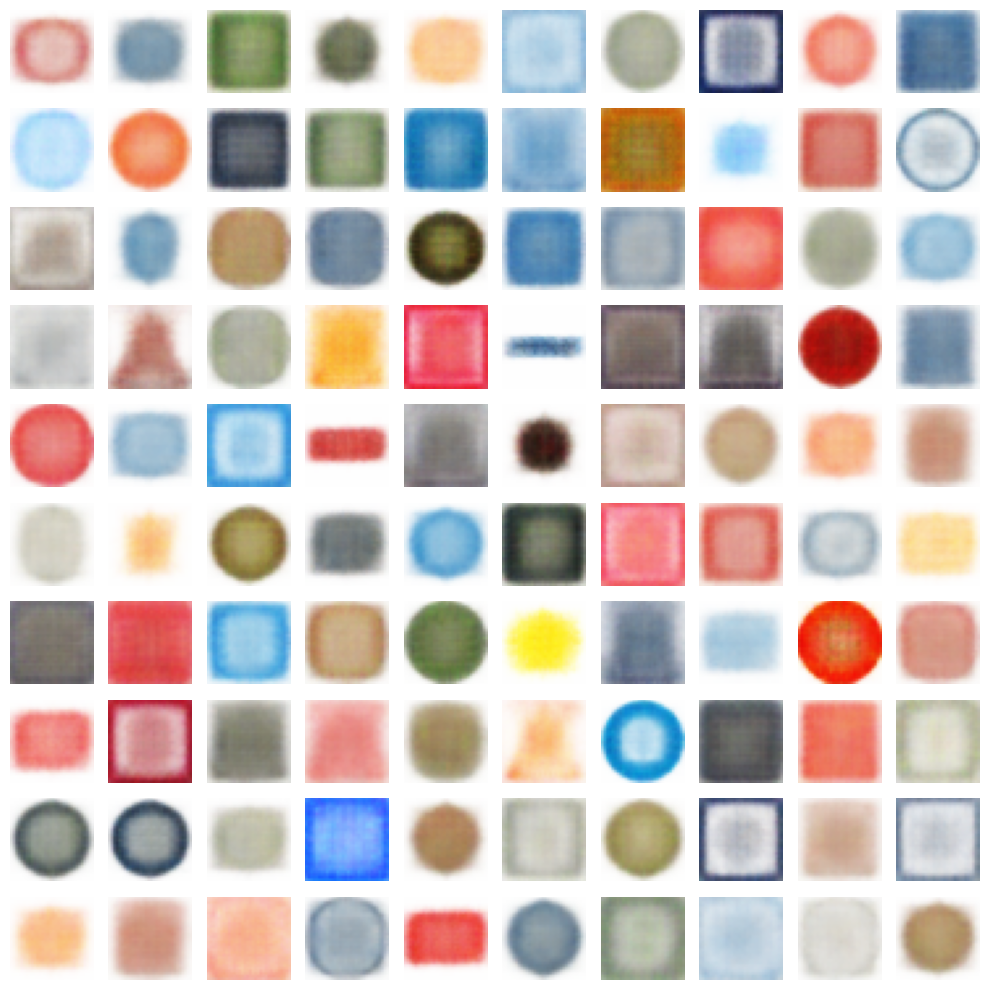

In [ ]:
# Chiamata della funzione per visualizzare la griglia di immagini generate
visualize_images()

#Calcolo del FID (Frechet Inception Distance)

Definiamo una funzione per calcolare il Frechet Inception Distance (FID) e confrontiamo immagini reali e generate.

In [ ]:
# Preparazione del modello InceptionV3
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Funzione per ridimensionare un array di immagini ad una nuova dimensione
def scale_images(images, new_shape):
    """
    Ridimensiona una collezione di immagini alla dimensione specifica (299x299x3).
    Args:
      	images: array o lista di immagini da ridimensionare.
      	new_shape: tupla che definisce la nuova dimensione.
    Return:
        Un array di immagini ridimensionate.
    """
    images_list = list()
    for image in images:
        # Ridimensiona l'immagine alla nuova dimensione.
        new_image = resize(image, new_shape, order=0)
        images_list.append(new_image)
    return asarray(images_list)

# Funzione per calcolare il Frechet Inception Distance (FID)
def calculate_fid(model, images1, images2):
    """
    Calcola il Frechet Inception Distance (FID) fra due insiemi di immagini.
    Args:
      	model: il modello InceptionV3 pre-addestrato utilizzato per estrarre le attivazioni.
     	  images1: primo set di immagini (immagini reali).
      	images2: secondo set di immagini (immagini generate).
    Return:
      	Il valore FID, una misura quantitativa della distanza tra le due distribuzioni.
    """
    # Estrae le attivazioni dal modello per ciascun set di immagini
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # Calcola la media e la matrice di covarianza delle attivazioni per ciascun set
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

    # Calcola la somma dei quadrati delle differenze tra le medie
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Calcola la radice matriciale del prodotto tra le covarianze
    covmean = sqrtm(sigma1.dot(sigma2))

    # Se il risultato contiene componenti immaginarie (a causa di errori numerici) le converte in parte reale
    if iscomplexobj(covmean):
        covmean = covmean.real

    # Calcolo del FID
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


##Preparazione dell'insieme delle immagini reali

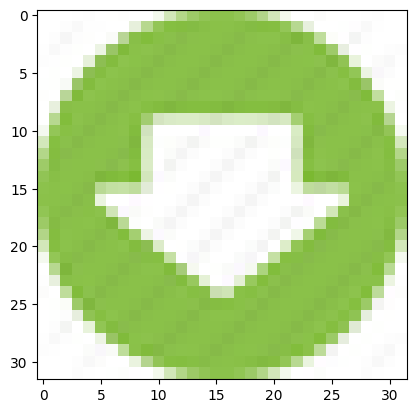

Valore minimo: 0.0
Valore massimo: 1.0


In [ ]:
# Numero di immagini da ottenere
num_images = 2000

# Lista delle immagini reali
images1 = []

# Itera sul dataset finché non raccogliamo almeno num_images immagini
for batch in dataset:
    images1.extend(batch.numpy())
    if len(images1) >= num_images:
        break

# Converte la lista in un array numpy e prende solo le prime num_images immagini
images1 = np.array(images1[:num_images])

# Visualizza la prima immagine per verifica
plt.imshow(images1[0])
plt.show()

# Controlla il valore minimo e massimo nell'intero array delle immagini
print("Valore minimo:", images1.min())
print("Valore massimo:", images1.max())

##Preparazione dell'insieme delle immagini generate

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


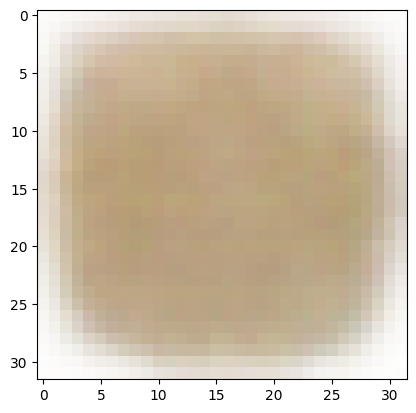

Valore minimo: 0.00024026964
Valore massimo: 1.0


In [ ]:
# Genera vettori casuali per lo spazio latente
random_latents = np.random.normal(size=(num_images, latent_dim))

# Genera le immagini direttamente dal decoder
images2 = vae.decoder.predict(random_latents)

# Visualizza un'immagine per verifica
plt.imshow(images2[0])
plt.show()

# Controlla il valore minimo e massimo nell'intero array delle immagini
print("Valore minimo:", images2.min())
print("Valore massimo:", images2.max())

##Calcolo della FID

In [ ]:
# Converte il tipo dei dati delle immagini in float32
images1 = images1.astype('float32')
images2 = images2.astype('float32')

# Per images1 normalizzate tra [0,1] le riporta a [0,255]
images1 = images1 * 255.0

# Ridimensiona le immagini al formato richiesto da InceptionV3
images1 = scale_images(images1, (299, 299, 3))
images2 = scale_images(images2, (299, 299, 3))
print('Immagini scalate:', images1.shape, images2.shape)

# Applica il preprocessamento specifico per InceptionV3, che trasforma immagini nel range [0,255] in immagini nel range [-1,1]
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# Calcolo FID
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

Scaled (2000, 299, 299, 3) (2000, 299, 299, 3)
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 317ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step
FID: 184.396
